In [1]:
%config Completer.use_jedi = False
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


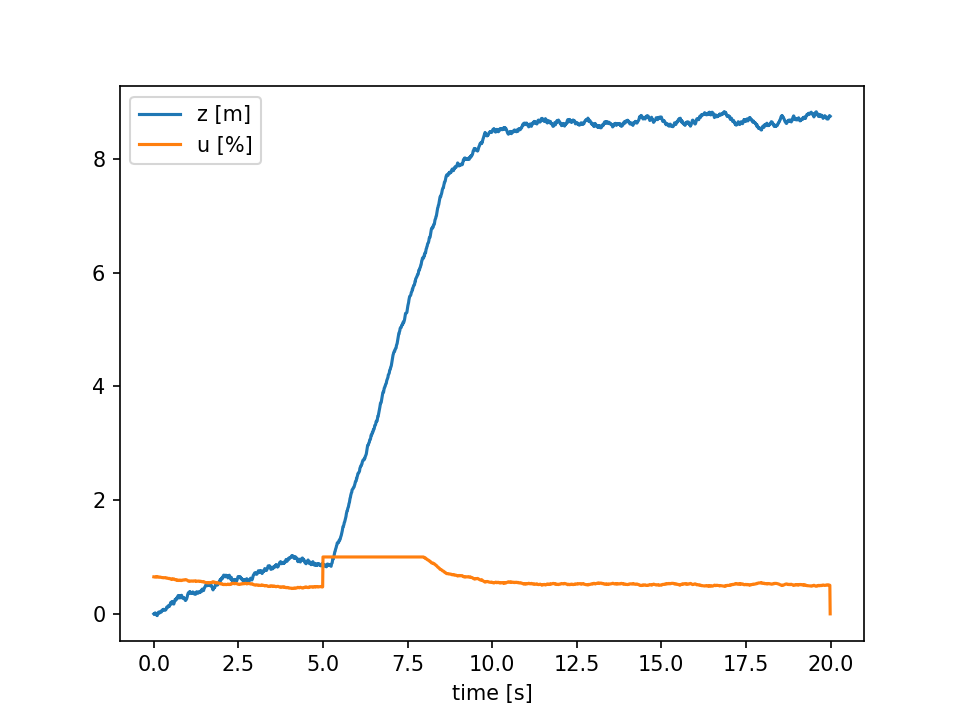

<IPython.core.display.Javascript object>


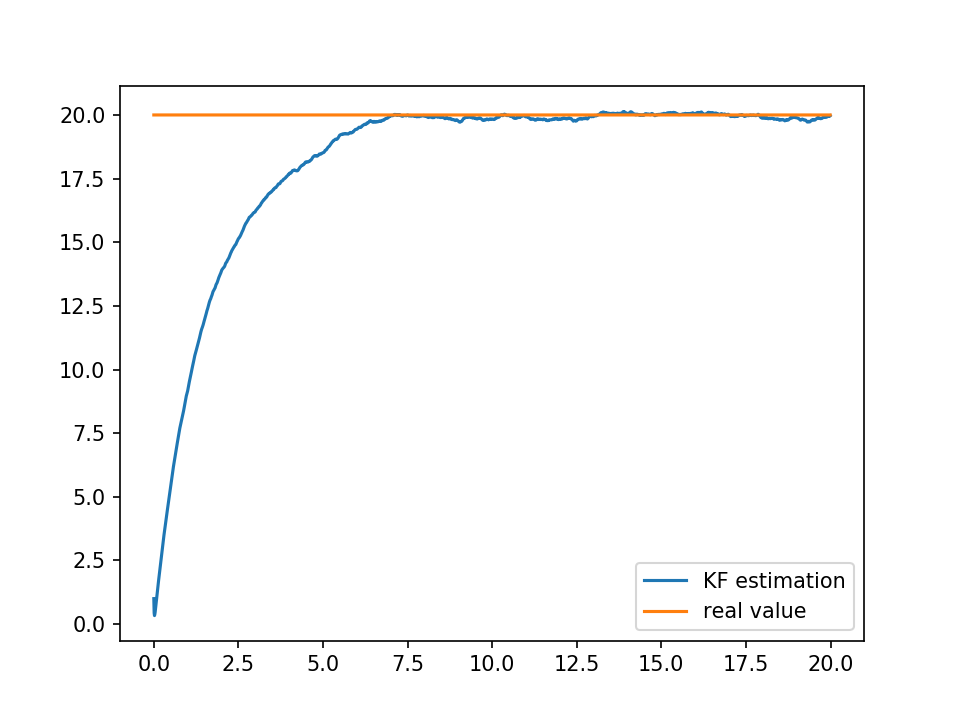

<IPython.core.display.Javascript object>


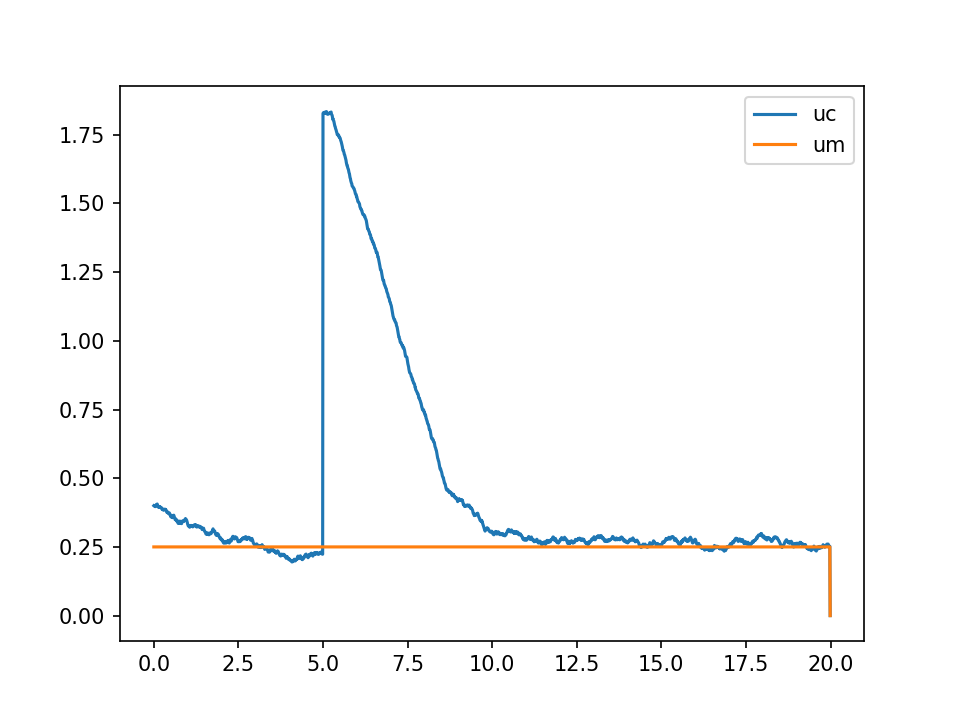

In [14]:
Te = 0.01
g = 10
α = 0.95
Tmax = 20
m = 1
kp = 0.2
N = 2000
Nd = 500
cte_gain = 0.25

zr = np.concatenate((2*np.ones(Nd),10*np.ones(N-Nd)))
xsys = np.zeros((N,2,1))
uk = np.zeros(N)
ukm = np.zeros(N)
ukc = np.zeros(N)

t = np.arange(0,N)*Te

X = np.ones((N,2,1))
I = np.eye(2)
C = np.array([[1,0]])

P = np.ones((2,2))
Q = np.ones((2,2))*1
R = 1

bx = 0.05

# Model for the KF
def f(xk,uk):
    xkp = np.zeros((2,1))
    vzk = xk[0]
    γk = xk[1]
    xkp[0] = α*vzk -Te*g + Te*γk*uk
    xkp[1] = γk
    return xkp

# Model for the drone
def fsys(xk,uk):
    xkp = np.zeros((2,1))
    vzk = xk[0]
    zk = xk[1]
    xkp[0] = α*vzk -Te*g + Te*uk*Tmax/m + (np.random.rand()-0.5)*bx
    xkp[1] = zk + Te*vzk + (np.random.rand()-0.5)*bx
    return xkp

# Compute all
for i in range(N-1):
    # Compute the command based on a P controller
    ukc[i] = kp*(zr[i] - xsys[i][1])
    # Add a fix compensation gain
    ukm[i] = cte_gain
    uk[i] = ukm[i] + ukc[i]
    # Saturation of the command between 0 and 1
    if uk[i] > 1:
        uk[i] = 1
    elif uk[i] < 0:
        uk[i] = 0
    #Compute the next state
    xsys[i+1] = fsys(xsys[i],uk[i])
    
    # Kalman filter
    # Prediction
    X[i+1] = f(X[i],uk[i])
    A = np.array([[α, Te*uk[i]],[0, 1]])
    P = A@P@A.T + Q
    # Update
    S = C@P@C.T + R
    K = P@C.T@np.linalg.inv(S)
    X[i+1] = X[i+1] + K*(xsys[i+1][0] - C@X[i+1])
    P = (I - K@C)@P

plt.close()
plt.figure()
plt.plot(t,xsys[:,1],label='z [m]')
# plt.plot(zr)
plt.plot(t,uk,label='u [%]')
plt.xlabel("time [s]")
plt.legend()
plt.figure()
plt.plot(t,X[:,1],label='KF estimation')
plt.plot(t,np.ones(N)*Tmax/m,label='real value')
plt.legend()
plt.figure()
plt.plot(t,ukc,label='uc')
plt.plot(t,ukm,label='um')
plt.legend()